# JHUPIEGO - RISE DATA DISCOVERY

## Import Libraries

In [1]:
import pandas as pd
import datetime as dt
import warnings
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import yaml
import os
user_dev_path = os.path.dirname(os.getcwd())
plt.style.use('fivethirtyeight')
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

## Working Functions**

In [2]:
def check_null_values(df):
    if df is not None:
        try:
            missing_value = df.isnull().sum()
            mis_val_percent = 100 * df.isnull().sum() / len(df)
            mis_val_table = pd.concat([missing_value, mis_val_percent], axis=1)
            mis_val_table_rename_cols = mis_val_table.rename(
                columns={0: "Missing Values", 1: "% of Total Values"}
            )
            mis_val_table_rename_cols = (
                mis_val_table_rename_cols[mis_val_table_rename_cols.iloc[:, 1] != 0]
                .sort_values("% of Total Values", ascending=False)
                .round(1)
            )
            print(
                "There are "
                + str(mis_val_table_rename_cols.shape[0])
                + " columns that have missing values"
            )
            return mis_val_table_rename_cols
        except Exception as e:
            print(f"Exception on checking missing values with error: {e}")
            
def load_excel_sheet(path: str):
    if path is not None:
        try:
            xls = pd.ExcelFile(path)
            df = xls.parse(skiprows=0)
            return df
        except Exception as e:
            print(f"Exception on loading excel spreadsheet with error: {e}")
            
def date_visit_conversion(df,visit_col: str,visit_year: str, visit_month: str):
    if df is not None:
        try:
            df = df.copy()
            df[visit_col] = pd.to_datetime(df[visit_col],errors='coerce')
            df[visit_year] = df[visit_col].dt.year
            df[visit_month] = df[visit_col].dt.month
            return df
        except Exception as e:
            print(f"Exception on converting visit date with error: {e}") 
            
def plot_visit_date(df, primary_key: str, data_name: str):
    if df is not None:
        df_sub = df.query("VISIT_YEAR > 1990 and VISIT_YEAR < 2022")
        df_sub_slice = df_sub.groupby("VISIT_YEAR").agg(
            {primary_key: lambda x: x.nunique()}
        )
        df_sub_slice.reset_index(inplace=True)
        df_sub_slice["VISIT_YEAR"] = df_sub_slice["VISIT_YEAR"].astype("int")
        ax_sub = sns.barplot(x="VISIT_YEAR", y=primary_key, data=df_sub_slice)
        ax_sub.set(xlabel="Year of Visit", ylabel="Number of Patient Visits")
        ax_sub.set_title(f"'Trend of Yearly Patient Visits:{data_name}'")
        plt.xticks(rotation=60)
        
def convert_to_datetime(df,date_col: str):
    if df is not None:
        try:
            df[date_col] = pd.to_datetime(df[date_col],errors='coerce')
            return df
        except Exception as e:
            print(f"Exception on converting to datetime with error: {e}")      

def print_min_max_dates(df,date_col: str,type_date: str):
    if df is not None:
        return print(f" The earliest {type_date} date is: {df[date_col].min()}, and the most recent {type_date} date is {df[date_col].max()}") 
    
def print_num_rows_cols(df, df_name: str):
        if df is not None:
            return print(f"{df_name} data has {df.shape[1]} columns and {df.shape[0]} rows.") 

# get indexing correct only showing last category
def categorical_bar_plots(df,unique_id):
    if df is not None:
        for i in df.columns[df.dtypes==object]:
            df_plot = df.groupby(i).agg({unique_id:lambda x: x.nunique()})
            df_plot.reset_index(inplace=True)
            ax = sns.barplot(x = i,y=unique_id,data=df_plot)
            ax.set_title(i)
            
def categorical_bar_plot(df):
    if df is not None:
        for i in df.columns[df.dtypes==object]:
            df[i].value_counts().plot(kind='bar')
            plt.title(i)
            plt.show()

## Loading Data

In [3]:
try: 
    with open (user_dev_path + '/' + 'config_LTFU.yaml', 'r') as file:
        config = yaml.safe_load(file)
except Exception as e:
    print(f'Error reading the config file, {e}')

In [4]:
# Get File paths and file names
input_root = config['rise_files']['raw_data_path']
eac_file = config['rise_files']['raw_eac_file']
otz_file = config['rise_files']['raw_otz_file']

# paths
eac_input = input_root + eac_file
otz_input = input_root + otz_file
print(eac_input)
print(' ')
print(otz_input)

/data/rise_data/EacData.xlsx
 
/data/rise_data/OtzData.xlsx


In [5]:
# EAC
df_eac_data = load_excel_sheet(eac_input)

# OTZ
df_otz_data = load_excel_sheet(otz_input)

## Initial Summary

### EAC 

In [18]:
print_num_rows_cols(df_eac_data,'DATE_EAC1')

DATE_EAC1 data has 13 columns and 14833 rows.


In [8]:
df_eac_data['LAST_VIRAL_LOAD'].value_counts()

0.0         13474
150.0          28
20.0           18
204176.0        8
23.0            7
            ...  
16520.0         1
7541.0          1
20908.0         1
12032.0         1
60718.0         1
Name: LAST_VIRAL_LOAD, Length: 1230, dtype: int64

In [6]:
df_eac_data = df_eac_data.sort_values(by=['PATIENT_ID','DATE_EAC1'])

In [19]:
print_min_max_dates(df_eac_data,'DATE_EAC1','EAC Session')

 The earliest EAC Session date is: 2010-09-22 00:00:00, and the most recent EAC Session date is 2028-10-31 00:00:00


In [7]:
df_eac_data.drop(columns=['DATE_SAMPLE_COLLECTED','NOTES','DATE_LAST_VIRAL_LOAD','LAST_VIRAL_LOAD','Facility Name','L.G.A','State','FACILITY_ID'],inplace=True)

In [8]:
df_eac_data.duplicated().sum()

0

In [9]:
df_eac_data = df_eac_data.drop_duplicates()

In [22]:
len(df_otz_data.query("patient_id  == 0"))

33

In [10]:
df_eac_data.PATIENT_ID.value_counts()

84372     7
85008     6
59493     6
84632     6
115707    5
         ..
71480     1
89913     1
52337     1
69435     1
53262     1
Name: PATIENT_ID, Length: 12237, dtype: int64

In [11]:
df_eac_data.query("PATIENT_ID == 59493")

EAC_ID  PATIENT_ID  DATE_EAC1            DATE_EAC2  DATE_EAC3
14216   14229       59493 2020-07-08  2020-09-22 00:00:00        NaT
6875     6887       59493 2020-07-09  2020-09-23 00:00:00        NaT
6579     6591       59493 2020-07-10  2020-09-24 00:00:00        NaT
14282   14295       59493 2020-08-21  2020-09-22 00:00:00 2021-02-04
13333   13346       59493 2020-08-22  2020-09-23 00:00:00 2021-02-04
12793   12806       59493 2020-08-23  2020-09-24 00:00:00 2021-02-04

In [12]:
df_eac_data['DATE_EAC1'] = pd.to_datetime(df_eac_data['DATE_EAC1'],errors="coerce")
df_eac_data['DATE_EAC2'] = pd.to_datetime(df_eac_data['DATE_EAC2'],errors="coerce")
df_eac_data['DATE_EAC3'] = pd.to_datetime(df_eac_data['DATE_EAC3'],errors="coerce")

In [13]:
df_check = df_eac_data[(df_eac_data.groupby('PATIENT_ID')
      ['DATE_EAC1']
      .diff(-1).dt.days.mul(-1) # calculate the difference
      .fillna(float('inf'))     # make sure last row is kept
      .ge(3)                    # select diff >= 4
   )]

In [14]:
df_check.query("PATIENT_ID == 59493")

EAC_ID  PATIENT_ID  DATE_EAC1  DATE_EAC2  DATE_EAC3
6579     6591       59493 2020-07-10 2020-09-24        NaT
12793   12806       59493 2020-08-23 2020-09-24 2021-02-04

In [15]:
df1 = pd.DataFrame({'ID':[110813,110813,110813,110813],
                   'DATE1':['2019-09-19','2020-05-20',pd.np.NaN,pd.np.NaN],
                   'DATE2':[pd.np.NaN,'2020-06-15',pd.np.NaN,'2019-10-24'],
                   'DATE3':[pd.np.NaN,'2020-07-20','2020-08-30',pd.np.NaN]})

In [16]:
df1

ID       DATE1       DATE2       DATE3
0  110813  2019-09-19         NaN         NaN
1  110813  2020-05-20  2020-06-15  2020-07-20
2  110813         NaN         NaN  2020-08-30
3  110813         NaN  2019-10-24         NaN

In [14]:
df_check.PATIENT_ID.value_counts()

115138    5
115707    5
111519    5
114659    5
111229    5
         ..
101936    1
121564    1
18074     1
118427    1
83967     1
Name: PATIENT_ID, Length: 12237, dtype: int64

In [17]:
df_check.query("PATIENT_ID == 115707")

EAC_ID  PATIENT_ID  DATE_EAC1  DATE_EAC2  DATE_EAC3
5409     5421      115707 2017-02-14 2017-04-26 2017-06-28
5446     5458      115707 2018-04-04 2018-05-02 2018-05-30
5467     5479      115707 2019-02-14        NaT        NaT
5405     5417      115707 2019-06-19 2019-07-17 2019-08-14
12037   12050      115707 2021-01-27        NaT        NaT

In [43]:
df_check.query("PATIENT_ID == 110813")

PATIENT_ID  DATE_EAC1  DATE_EAC2  DATE_EAC3
5267      110813 2019-09-19        NaT        NaT
8760      110813 2020-05-20 2020-06-15 2020-07-20
5214      110813        NaT        NaT 2019-12-19
5256      110813        NaT 2019-10-24        NaT

In [45]:
df1

ID       DATE1       DATE2       DATE3
0  110813  2019-09-19         NaN         NaN
1  110813  2020-05-20  2020-06-15  2020-07-20
2  110813         NaN         NaN  2020-08-30
3  110813         NaN  2019-10-24         NaN

In [18]:
out_df = (
    df1.set_index('ID')
        .stack(dropna=False)
        .droplevel(1)
        .reset_index(name='DATE')
)

In [19]:
out_df

ID        DATE
0   110813  2019-09-19
1   110813         NaN
2   110813         NaN
3   110813  2020-05-20
4   110813  2020-06-15
5   110813  2020-07-20
6   110813         NaN
7   110813         NaN
8   110813  2020-08-30
9   110813         NaN
10  110813  2019-10-24
11  110813         NaN

In [27]:
long_df = (pd.wide_to_long(df_check,
                           stubnames='DATE',
                           i=['PATIENT_ID','DATE1','DATE2','DATE3'],
                           j='DATEs'))

In [28]:
long_df.head()

Empty DataFrame
Columns: [DATE]
Index: []

In [ ]:
df_long = pd.wide_to_long(df_check, ["DATE", "B"], i="id", j="year")

In [ ]:
long_df = pd.melt(df,
                  id_vars=['EAC_ID', 'PATIENT_ID', 'date.entered'],
                  value_vars=[x for x in df_check.columns if 'DATE' in x],
                  var_name='week',
                  value_name='position')
long_df['week'] = long_df['week'].str.extract(r'(\d+)')

In [30]:
df_eac_data.duplicated().sum()

0

In [31]:
df_eac_data.PATIENT_ID.nunique(), len(df_eac_data)

(12237, 14795)

In [20]:
pd.set_option('max.rows',None)
df_eac_data.PATIENT_ID.value_counts()

84372     7
85008     6
84632     6
59493     6
82533     5
115707    5
82905     5
82322     5
115138    5
82459     5
57073     5
111519    5
23872     5
57469     5
56812     5
57523     5
114659    5
82935     5
82669     5
57291     5
111229    5
75809     5
85259     5
59621     5
84722     5
19104     5
82915     4
57260     4
56764     4
83575     4
57818     4
58970     4
57118     4
57672     4
75886     4
56941     4
114906    4
14308     4
58994     4
82360     4
82697     4
85345     4
84637     4
57430     4
58123     4
56838     4
150537    4
83760     4
83385     4
59184     4
33886     4
58276     4
84889     4
59086     4
115789    4
56915     4
84207     4
56671     4
58417     4
59199     4
32129     4
57004     4
107551    4
57358     4
29655     4
57023     4
83000     4
119600    4
84366     4
35272     4
58928     4
57412     4
78271     4
78306     4
59626     4
58899     4
84259     4
57791     4
84795     4
59289     4
57771     4
83231     4
28281     4
8282

In [28]:
df_eac_data['DATE_EAC2'] = pd.to_datetime(df_eac_data['DATE_EAC2'], errors="coerce")
df_eac_data['DATE_SAMPLE_COLLECTED'] = pd.to_datetime(df_eac_data['DATE_SAMPLE_COLLECTED'], errors="coerce")

In [32]:
m = df_eac_data.groupby('PATIENT_ID').DATE_EAC1.apply(lambda x: x.diff().dt.days < 3)
m2 = df_eac_data.PATIENT_ID.duplicated(keep="last") & (m | m.shift(-1))
maz= df_eac_data[~m2]

In [ ]:
# m = df.groupby('B').A.apply(lambda x: x.diff().dt.days < 3)
# m2 = df.B.duplicated(keep=False) & (m | m.shift(-1))
# df[~m2]

In [6]:
df_eac_data.columns

Index(['State', 'L.G.A', 'Facility Name', 'EAC_ID', 'FACILITY_ID',
       'PATIENT_ID', 'DATE_EAC1', 'DATE_EAC2', 'DATE_EAC3',
       'DATE_SAMPLE_COLLECTED', 'NOTES', 'LAST_VIRAL_LOAD',
       'DATE_LAST_VIRAL_LOAD'],
      dtype='object')

In [7]:
df_eac_data.describe()

EAC_ID   FACILITY_ID     PATIENT_ID  NOTES  LAST_VIRAL_LOAD
count  14833.000000  14833.000000   14833.000000    0.0     1.483300e+04
mean    7428.262792   2643.202993   69094.882155    NaN     1.147636e+04
std     4282.398182   3613.566106   37346.972709    NaN     1.483358e+05
min       12.000000    421.000000    8290.000000    NaN     0.000000e+00
25%     3720.000000    459.000000   36928.000000    NaN     0.000000e+00
50%     7428.000000    614.000000   63204.000000    NaN     0.000000e+00
75%    11137.000000   2818.000000   99018.000000    NaN     0.000000e+00
max    14845.000000  10026.000000  160680.000000    NaN     1.000000e+07

In [9]:
check_null_values(df_eac_data)

There are 6 columns that have missing values


Missing Values  % of Total Values
NOTES                           14833              100.0
DATE_LAST_VIRAL_LOAD            13304               89.7
DATE_SAMPLE_COLLECTED            9872               66.6
DATE_EAC3                        6112               41.2
DATE_EAC2                        4021               27.1
DATE_EAC1                          43                0.3

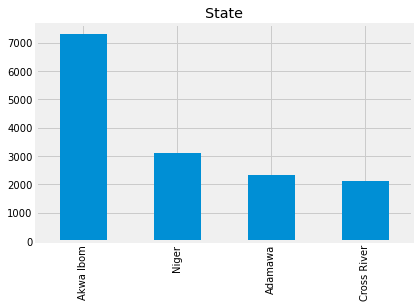

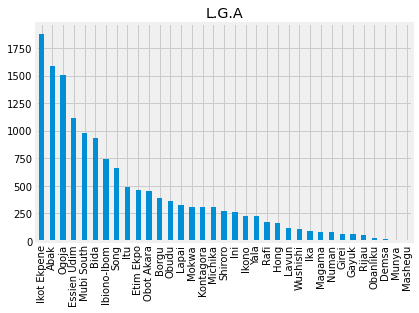

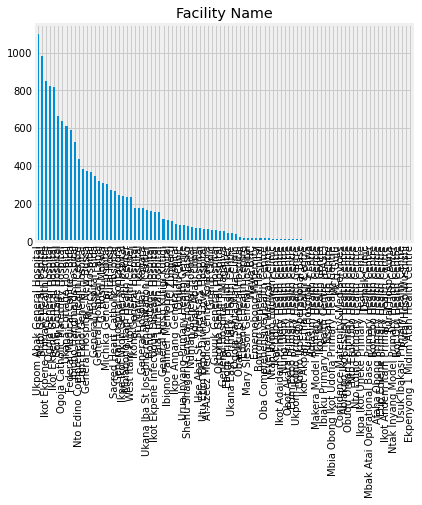

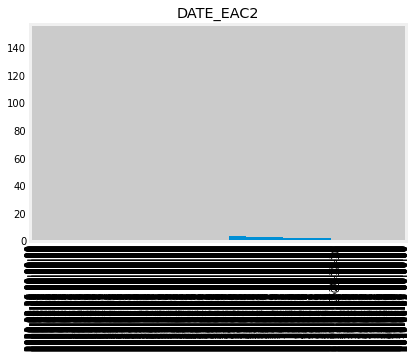

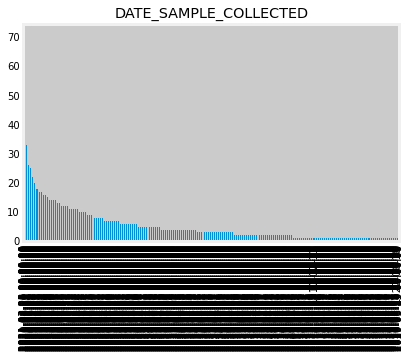

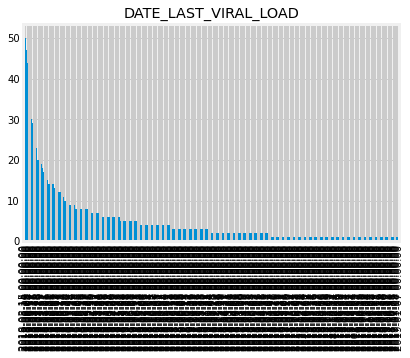

In [45]:
categorical_bar_plot(df_eac_data)

In [22]:
df_check = df_eac_data.query("PATIENT_ID == 144642")
df_check['sum'] = df_check.loc[:,'DATE_EAC1'].notnull().astype(int) + df_check.loc[:,'DATE_EAC2'].notnull().astype(int) + df_check.loc[:,'DATE_EAC3'].notnull().astype(int)

<ipython-input-22-14cd5ce0f5cf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_check['sum'] = df_check.loc[:,'DATE_EAC1'].notnull().astype(int) + df_check.loc[:,'DATE_EAC2'].notnull().astype(int) + df_check.loc[:,'DATE_EAC3'].notnull().astype(int)


In [11]:
df_eac_data['PATIENT_ID'].nunique(),len(df_eac_data)

(12237, 14833)

In [26]:
df_otz_data['patient_id'].nunique(),len(df_otz_data)

(5470, 6431)

### OTZ

In [23]:
print_num_rows_cols(df_otz_data,'OTZ')

OTZ data has 17 columns and 6431 rows.


In [24]:
df_otz_data.columns

Index(['State', 'L.G.A', 'Facility Name', 'otz_id', 'facility_id',
       'patient_id', 'full_disclosure', 'date_enrolled_otz',
       'date_enrolled_otz_plus', 'date_module1', 'date_module2',
       'date_module3', 'date_module4', 'date_module5', 'date_module6',
       'date_module7', 'date_transitioned'],
      dtype='object')

In [12]:
df_otz_data.describe()

otz_id   facility_id     patient_id  full_disclosure
count  6431.000000   6431.000000    6431.000000      6431.000000
mean   3223.700513   2328.887420   79420.320012         0.875758
std    1861.846054   3448.667784   39949.419363         0.329883
min       1.000000    421.000000       0.000000         0.000000
25%    1608.500000    505.000000   50390.000000         1.000000
50%    3227.000000    614.000000   84388.000000         1.000000
75%    4834.500000   1753.000000  111265.500000         1.000000
max    6452.000000  10025.000000  160308.000000         1.000000

In [14]:
check_null_values(df_otz_data)

There are 9 columns that have missing values


Missing Values  % of Total Values
date_transitioned                 6428              100.0
date_module7                      6427               99.9
date_module6                      6424               99.9
date_module5                      6415               99.8
date_module4                      6321               98.3
date_module3                      6261               97.4
date_module2                      6104               94.9
date_enrolled_otz_plus            5512               85.7
date_module1                      5186               80.6

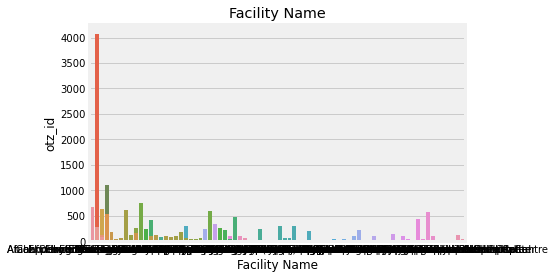

In [43]:
categorical_bar_plots(df_otz_data,'otz_id')

Text(0.5, 1.0, 'State')

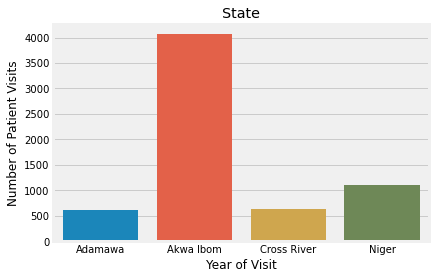

In [23]:
i = 'State'
unique_id = 'otz_id'
df_plot = df_otz_data.groupby(i).agg({unique_id:lambda x: x.nunique()})
df_plot.reset_index(inplace=True)
ax_ada = sns.barplot(x = i,y=unique_id,data=df_plot)
ax_ada.set_title(i)
ax_dad

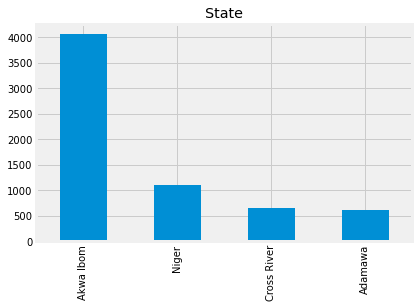

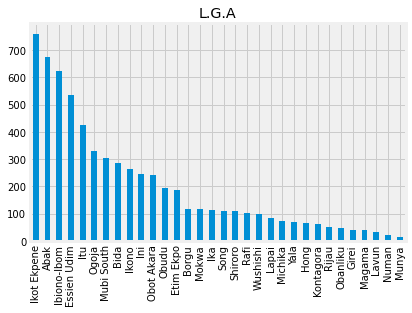

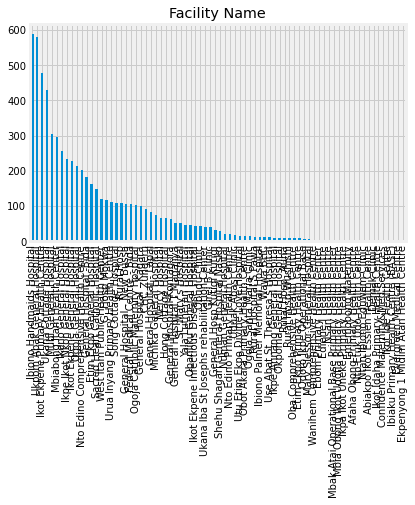

In [21]:
categorical_bar_plot(df_otz_data)

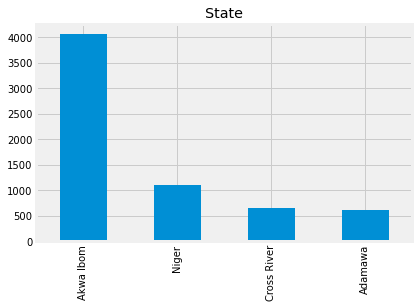

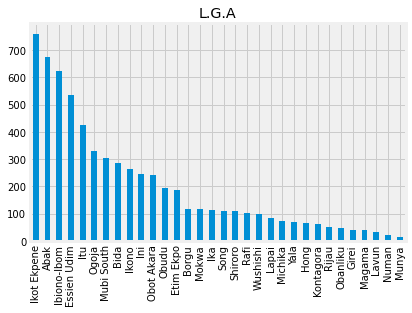

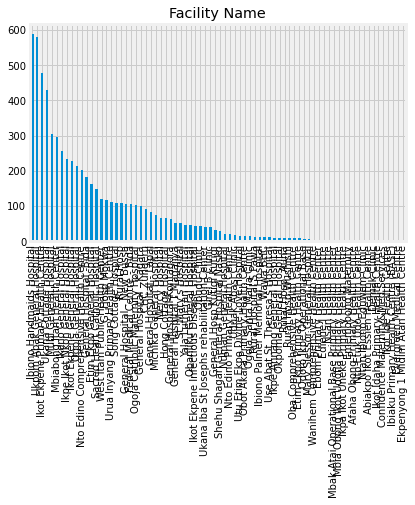

In [16]:
for i in df_otz_data.columns[df_otz_data.dtypes==object]:
    df_otz_data[i].value_counts().plot(kind='bar')
    plt.title(i)
    plt.show()